country — наименование страны;
date — дата наблюдения;
total_vaccinations — общее число введённых вакцин в стране на указанный день;
people_vaccinated — общее число привитых первым компонентом в стране на указанный день;
people_vaccinated_per_hundred — процент привитых первым компонентом в стране на указанный день (рассчитывается как );
people_fully_vaccinated — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);
people_fully_vaccinated_per_hundred — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );
daily_vaccination — ежедневная вакцинация (число вакцинированных в указанный день);
vaccines — комбинации вакцин, используемые в стране.

 date — дата наблюдения;
 province/state — наименование провинции/штата;
 country — наименование страны;
 confirmed — общее число зафиксированных случаев на указанный день;
 deaths — общее число зафиксированных смертей на указанный день;
 recovered — общее число выздоровлений на указанный день.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
%matplotlib inline
plt.style.use('default')

covid_url = 'https://raw.githubusercontent.com/Ar1sha/sf/master/Pandas/covid_data.csv'
vacc_url = 'https://raw.githubusercontent.com/Ar1sha/sf/master/Pandas/country_vaccinations.csv'
covid_df = pd.read_csv(covid_url, sep=',')
vaccinations_data = pd.read_csv(vacc_url, sep=',')


In [79]:
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [80]:
#Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам
covid_df = covid_df.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()
#Преобразуем даты в формат datetime с помощью функции pd.to_datetime():
covid_df['date'] = pd.to_datetime(covid_df['date'])
#Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов
covid_df['active'] = covid_df['confirmed'] - covid_df['deaths'] - covid_df['recovered']
#Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
#Для этого отсортируем данные по названиям стран, а затем по датам. 
# После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff()
covid_df = covid_df.sort_values(by=['country', 'date'])
covid_df['daily_confirmed'] = covid_df.groupby('country')['confirmed'].diff()
covid_df['daily_deaths'] = covid_df.groupby('country')['deaths'].diff()
covid_df['daily_recovered'] = covid_df.groupby('country')['recovered'].diff()

In [81]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])
covid_df['date']

11337   2020-02-24
11570   2020-02-25
11807   2020-02-26
12051   2020-02-27
12299   2020-02-28
           ...    
15933   2020-03-12
16595   2020-03-14
16938   2020-03-15
17290   2020-03-16
17645   2020-03-17
Name: date, Length: 86785, dtype: datetime64[ns]

In [82]:
covid_df_merged = covid_df.merge(
    vaccinations_data,
    on=['country', 'date'],
    how='left',
    ).query("'2020-01-22'<= date <= '2021-05-29'")
covid_df_merged.shape

(86785, 16)

In [83]:
covid_df_merged['death_rate'] = (covid_df_merged['deaths'] / covid_df_merged['confirmed'])*100
covid_df_merged['recover_rate'] = (covid_df_merged['recovered']/ covid_df_merged['confirmed'])*100

<Axes: title={'center': 'Ежедневная заболеваемость во времени'}, xlabel='date'>

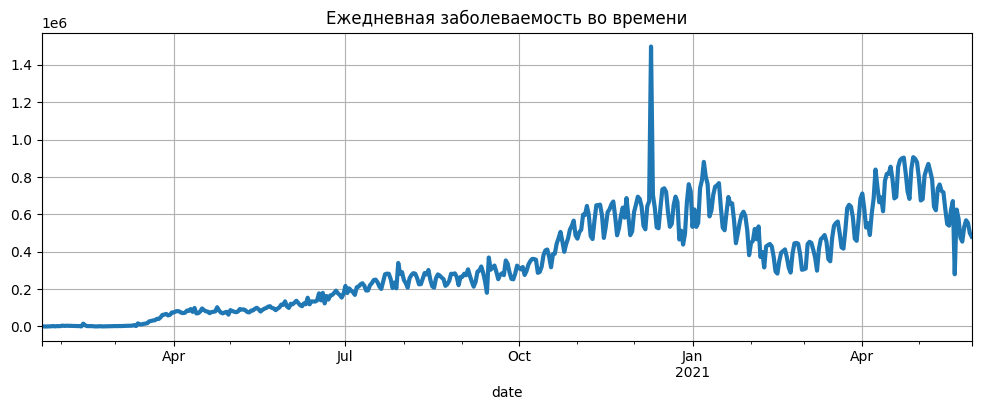

In [84]:
grouped_cases = covid_df_merged.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
)

<Axes: title={'center': 'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

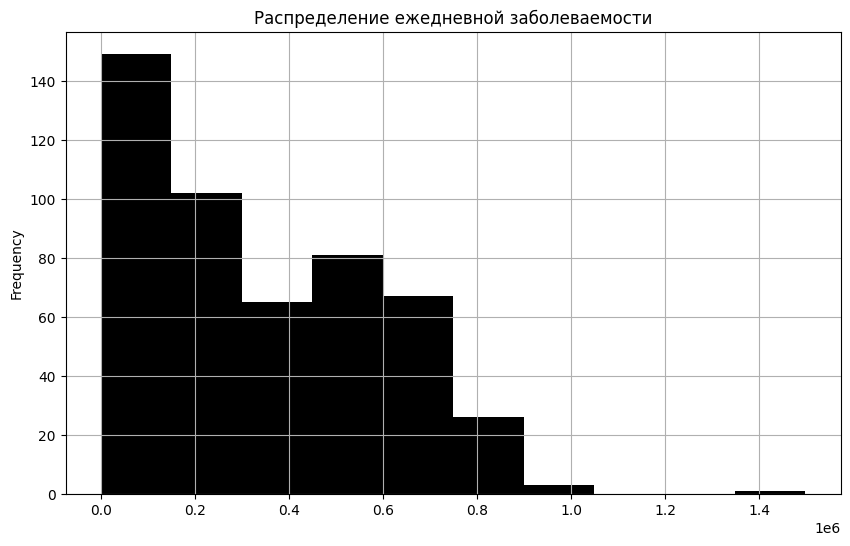

In [85]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
)

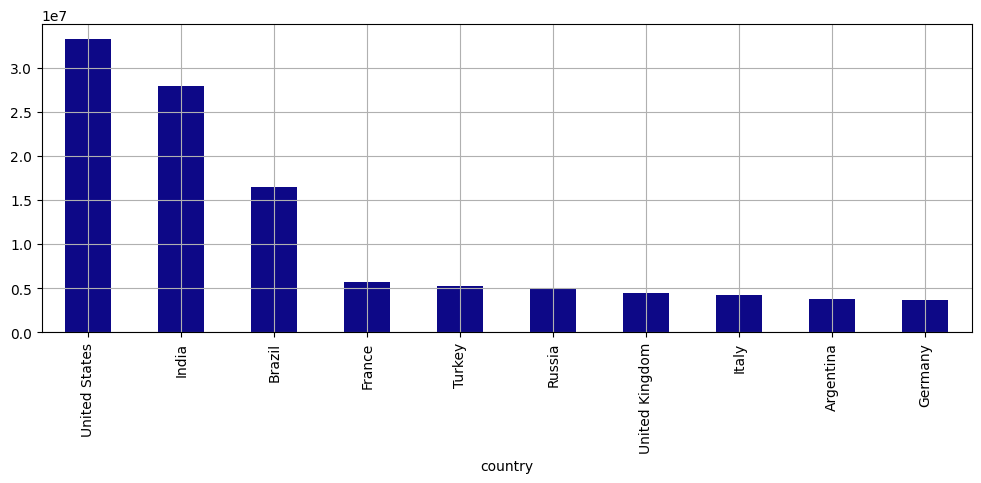

In [86]:
grouped_country = covid_df_merged.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

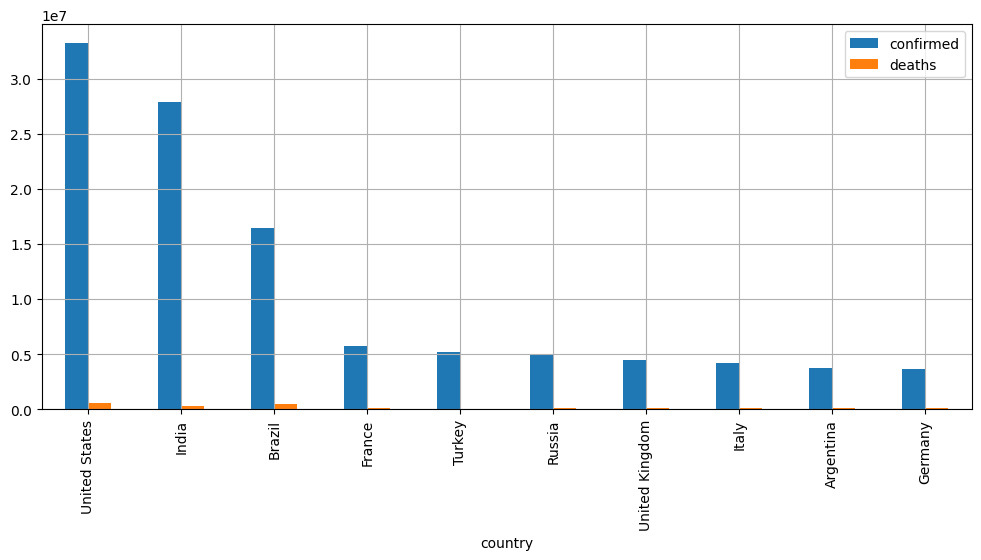

In [87]:
grouped_country = covid_df_merged.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(12, 5), );

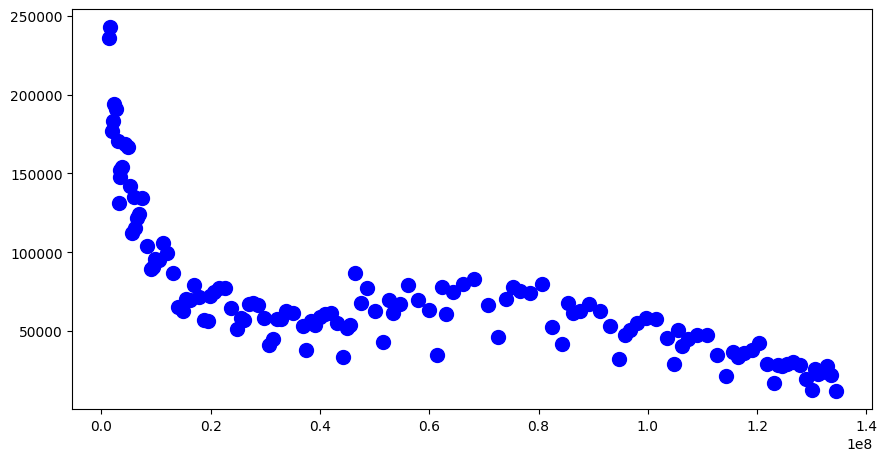

In [88]:
us_data = covid_df_merged[covid_df_merged['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
)

([<matplotlib.patches.Wedge at 0x25dbb7356d0>,
 [Text(0.7665420850598537, 0.9232622768380024, 'Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(-0.593147054630085, 0.9263782011595778, 'Oxford/AstraZeneca'),
  Text(-1.0669756914402408, 0.2675123807894132, 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(-0.9691396926701603, -0.520353971918335, 'Oxford/AstraZeneca, Sinopharm/Beijing'),
  Text(-0.4285588134061492, -1.0130830881284683, 'Oxford/AstraZeneca, Pfizer/BioNTech'),
  Text(0.16276478967892033, -1.0878913655511644, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'),
  Text(0.6404450594641427, -0.894332223397978, 'Moderna, Pfizer/BioNTech'),
  Text(0.9150659290417462, -0.6104542124573851, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing'),
  Text(1.0347732735903306, -0.37315448846711075, 'Pfizer/BioNTech'),
  Text(1.0927241988120744, -0.12630845312373262, 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V')],
 [Text(0.4471

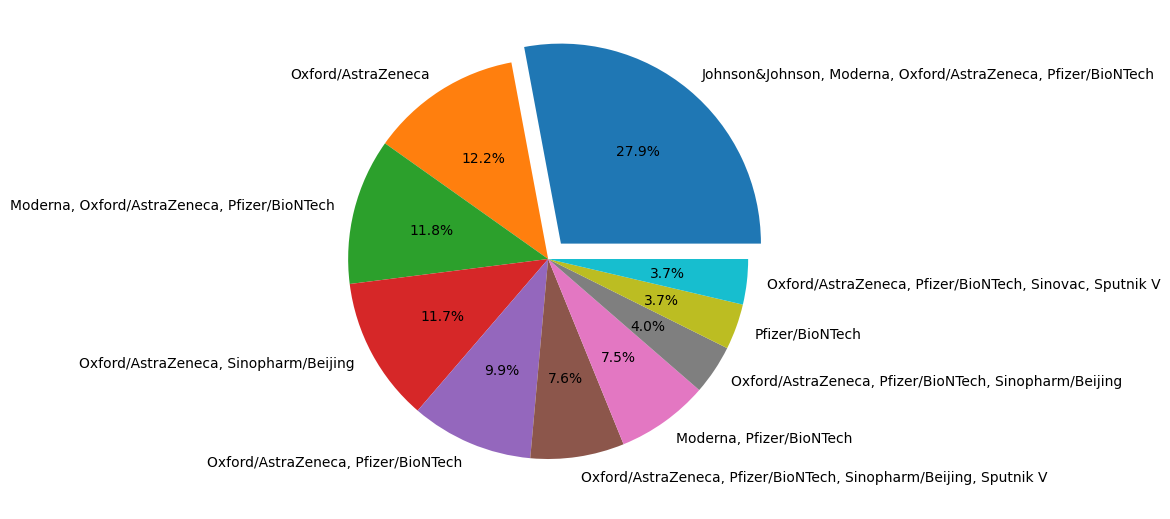

In [89]:
vaccine_combinations = covid_df_merged['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
)

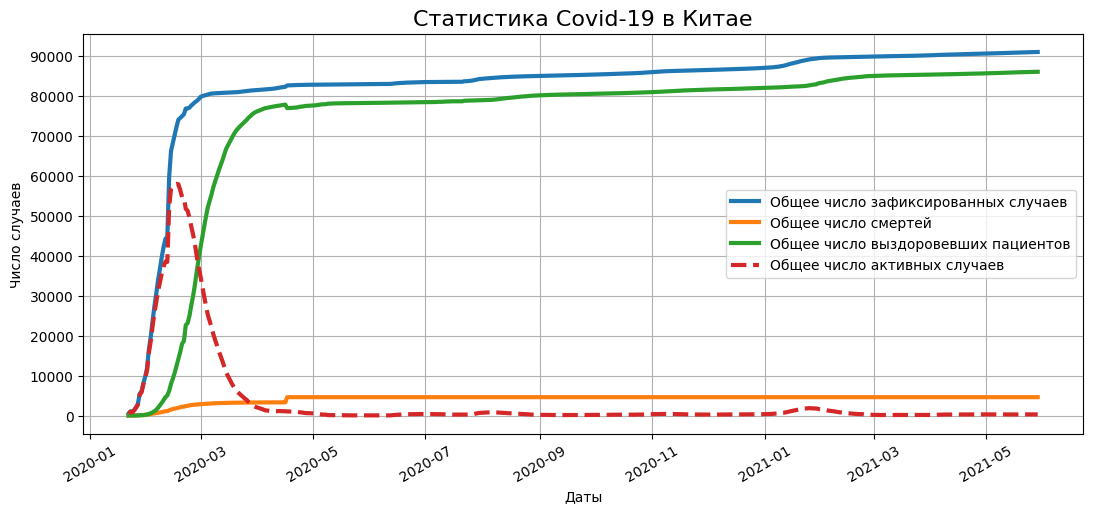

In [90]:
china_data = covid_df_merged[covid_df_merged['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend()

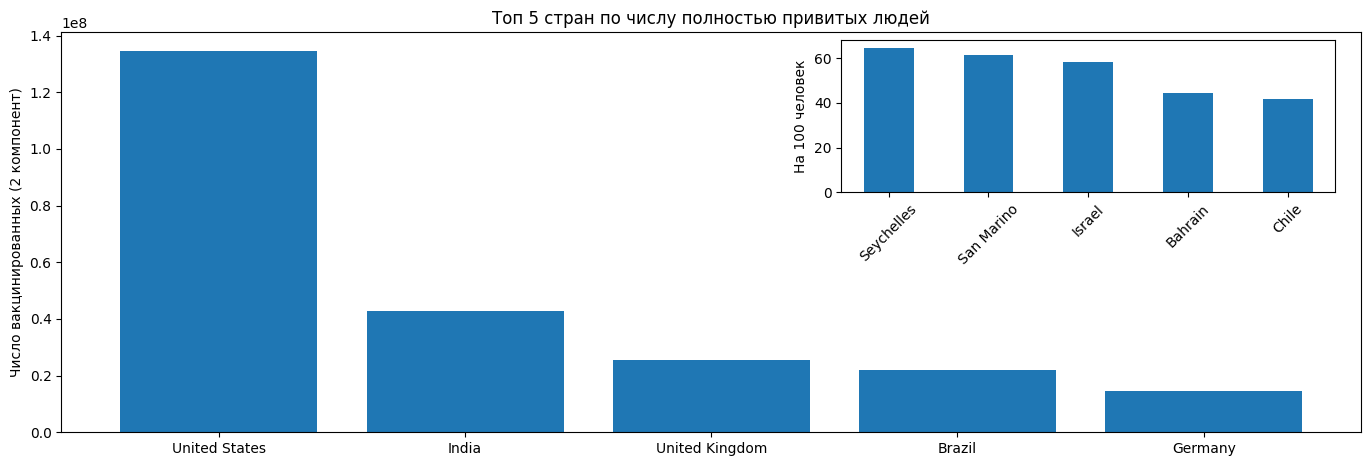

In [91]:
vacc_country = covid_df_merged.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df_merged.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

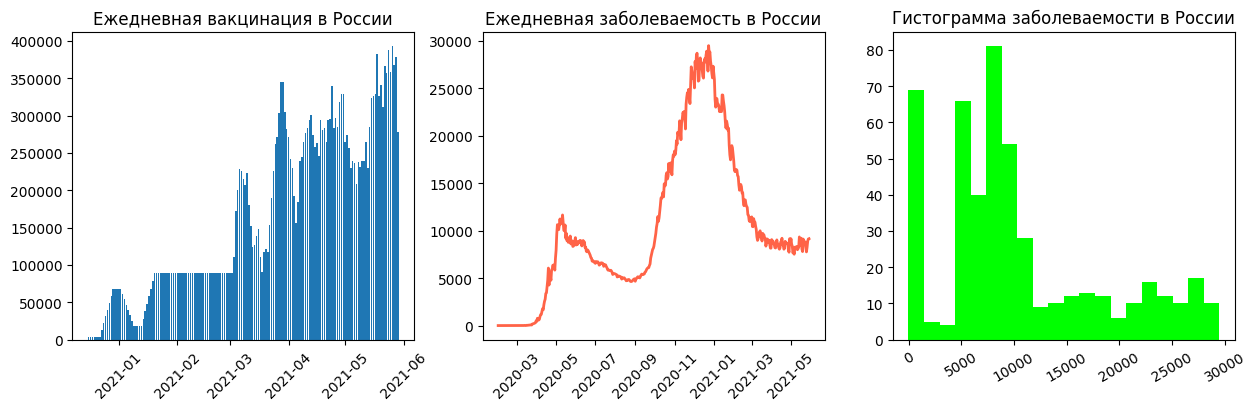

In [92]:
russia_data = covid_df_merged[covid_df_merged["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)

In [93]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df_merged[covid_df_merged['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

date    country  confirmed  deaths  recovered  active  \
0 2020-01-23  Australia        0.0     0.0        0.0     0.0   
1 2020-01-25  Australia        4.0     0.0        0.0     4.0   
2 2020-01-26  Australia        4.0     0.0        0.0     4.0   
3 2020-01-27  Australia        5.0     0.0        0.0     5.0   
4 2020-01-28  Australia        5.0     0.0        0.0     5.0   

   daily_confirmed  daily_deaths  daily_recovered  total_vaccinations  \
0              NaN           NaN              NaN                 NaN   
1              4.0           0.0              0.0                 NaN   
2              0.0           0.0              0.0                 NaN   
3              1.0           0.0              0.0                 NaN   
4              0.0           0.0              0.0                 NaN   

   people_vaccinated  people_vaccinated_per_hundred  people_fully_vaccinated  \
0                NaN                            NaN                      NaN   
1                NaN                            NaN                      NaN   
2                NaN                            NaN                      NaN   
3                NaN                            NaN                      NaN   
4                NaN                            NaN                      NaN   

   people_fully_vaccinated_per_hundred  daily_vaccinations vaccines  \
0                                  NaN                 NaN      NaN   
1                                  NaN                 NaN      NaN   
2                                  NaN                 NaN      NaN   
3                                  NaN                 NaN      NaN   
4                                  NaN                 NaN      NaN   

   death_rate  recover_rate  population  daily_confirmed_per_hundred  
0         NaN           NaN    25726900                          NaN  
1         0.0           0.0    25726900                     0.000016  
2         0.0           0.0    25726900                     0.000000  
3         0.0           0.0    25726900                     0.000004  
4         0.0           0.0    25726900                     0.000000

In [94]:
croped_covid_df.columns

Index(['date', 'country', 'confirmed', 'deaths', 'recovered', 'active',
       'daily_confirmed', 'daily_deaths', 'daily_recovered',
       'total_vaccinations', 'people_vaccinated',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations', 'vaccines',
       'death_rate', 'recover_rate', 'population',
       'daily_confirmed_per_hundred'],
      dtype='object')

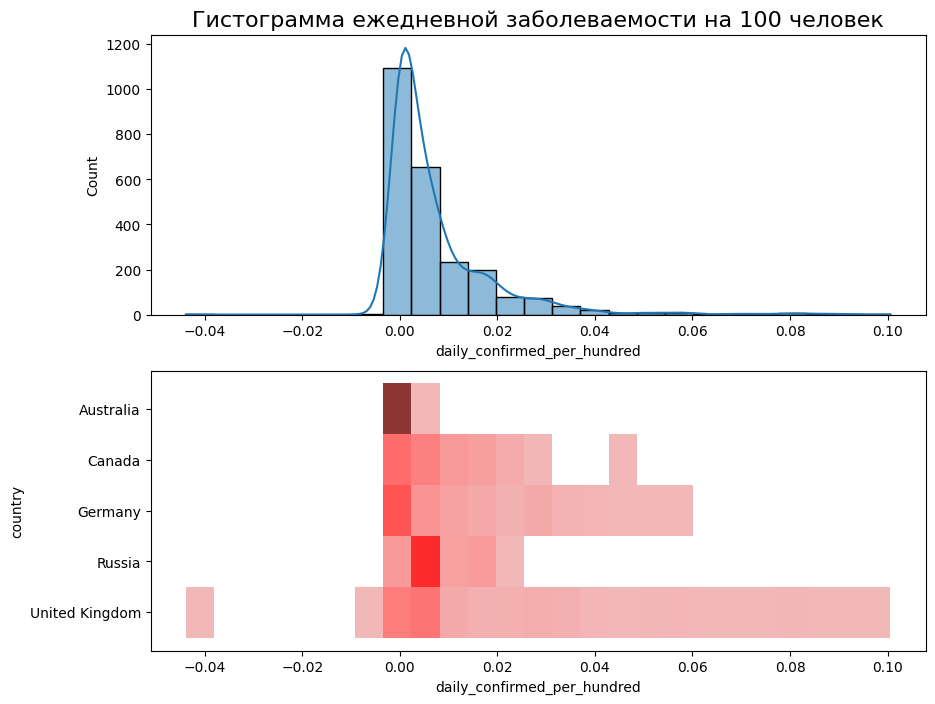

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

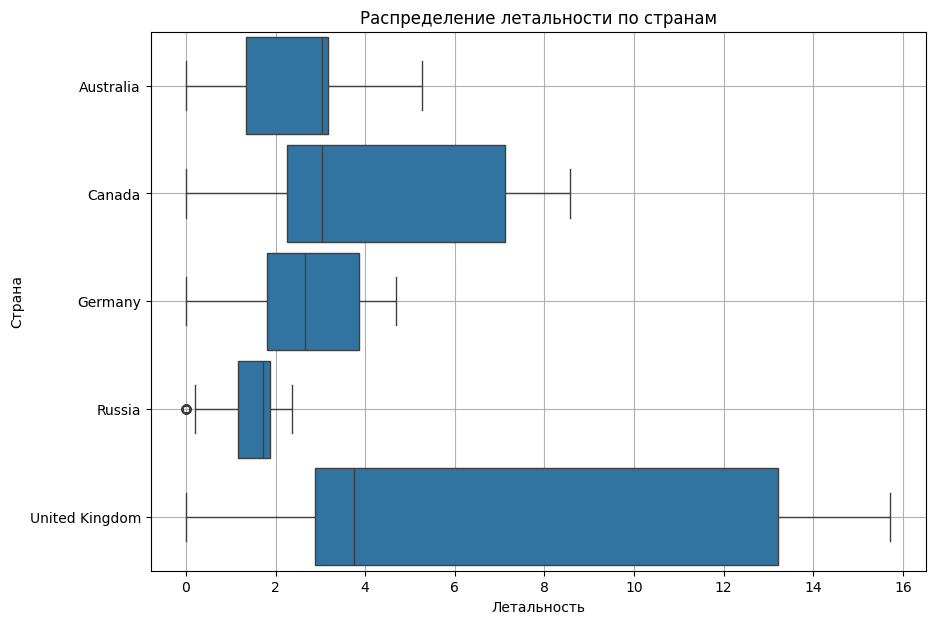

In [96]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

In [ ]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

In [ ]:
jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8,
)

In [ ]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

In [ ]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16)

In [ ]:
croped_covid_df['confirmed_per_hundred'] = croped_covid_df['confirmed']/ croped_covid_df['population']*100

In [ ]:
pivot = croped_covid_df.pivot(
    values = 'confirmed_per_hundred',
    index = 'country',
    columns='date'
)
display(pivot)

In [ ]:
heatmap = sns.heatmap(data = pivot, cmap='YlGnBu' )
heatmap.set_title('Тепловая карта заболеваемости', fontsize= 16)

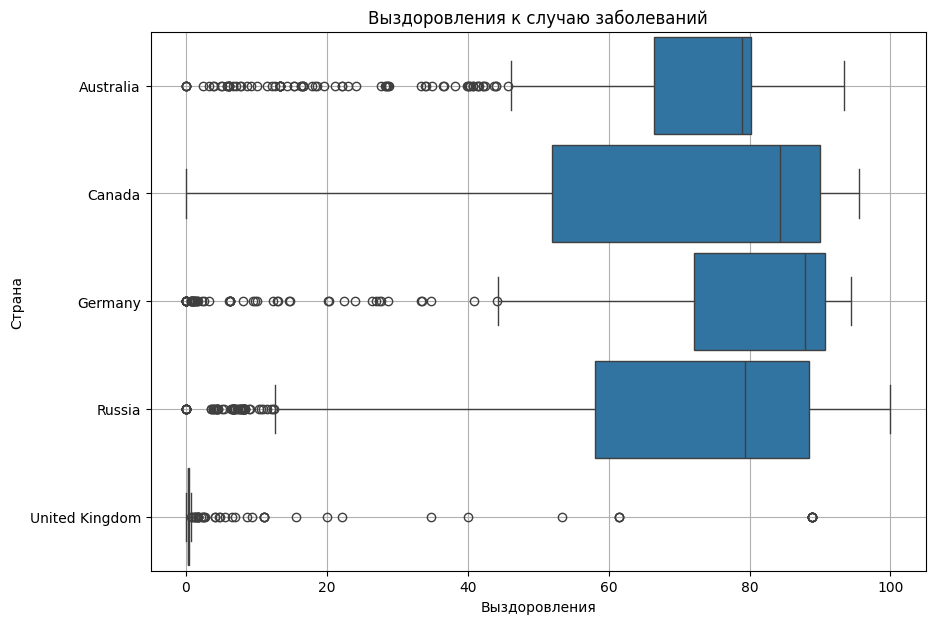

In [118]:
fig = plt.figure(figsize=(10,7))
boxplot = sns.boxplot(
    data = croped_covid_df,
    x='recover_rate',
    y='country',
    orient='h',
    width=0.9
)
boxplot.set_title('Выздоровления к случаю заболеваний')
boxplot.set_xlabel('Выздоровления')
boxplot.set_ylabel('Страна')
boxplot.grid()

In [121]:
line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

In [123]:
#считаем средний процент выздоровлений для каждой страны
bar_data = covid_df_merged.groupby(
    by='country',
    as_index=False
)[['recover_rate']].mean().round(2).nlargest(10, columns=['recover_rate'])

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="country", #ось x
    y="recover_rate", #ось y
    color='country', #расцветка в зависимости от страны
    text = 'recover_rate', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Top 10 Countries for Recovery Rate' #заголовок
)

#отображаем его
fig.show()

In [124]:
#считаем среднее ежедневно фиксируемое количество выздоровевших по странам
treemap_data = covid_df_merged.groupby(
    by='country',
    as_index=False
)[['daily_recovered']].mean()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #DataFrame
    path=['country'], #категориальный признак, для которого строится график
    values='daily_recovered', #параметр, который сравнивается
    height=500, #высота
    width=1000, #ширина
    title='Daily Recovered Cases by Country' #заголовок
)

#отображаем график
fig.show()

In [139]:
#преобразуем даты в строковый формат
choropleth_data = covid_df_merged.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

#строим график
fig = px.choropleth(
    data_frame=choropleth_data, #DataFrame
    locations="country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="confirmed", #от чего зависит цвет
    animation_frame="date", #анимационный бегунок
    range_color=[0, 30e6], #диапазон цвета
    title='Global Spread of COVID-19', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show()

In [126]:
#фильтруем таблицу по странам
countries=['United States', 'Russia', 'United Kingdom', 'Brazil', 'France']
scatter_data = covid_df_merged[covid_df_merged['country'].isin(countries)]

#строим график
fig = px.scatter_3d(
    data_frame=scatter_data, #DataFrame
    x = 'daily_confirmed', #ось абсцисс
    y = 'daily_deaths', #ось ординат
    z = 'daily_vaccinations', #ось аппликат
    color='country', #расцветка в зависимости от страны
    log_x=True, 
    log_y=True,
    width=1000,
    height=700
)

#отображаем график
fig.show()
fig.write_html("plotly/scatter_3d.html")

FileNotFoundError: [Errno 2] No such file or directory: 'plotly\\scatter_3d.html'

In [129]:

countries=['United States', 'Russia', 'United Kingdom', 'Brazil', 'France']
box_data = covid_df_merged[covid_df_merged['country'].isin(countries)]
fig = px.box(data_frame=box_data, x = 'total_vaccinations', color='country')
fig.show()

In [ ]:
line_data = covid_df_merged.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame = line_data,
    x='date',
    y=['daily_vaccinations'],
    height=500,
    width=1000,
    title='Кол-во вакцинированных с учетом времени'
 )
fig.show()

In [144]:
choropleth_data = covid_df_merged.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

fig = px.choropleth(
    data_frame=choropleth_data,
    locations='country',
    locationmode='country names',
    color='total_vaccinations',
    animation_frame='date',
    range_color=[0, 30e6],
    title='total vaccinations',
    width=1200,
    height=500,
    color_continuous_scale='Reds'
)
fig.show()